#**Predicting Recessions with Economic Indicators**

#Loading Data from *FRED*

In [58]:
!pip install pandas_datareader
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from datetime import datetime

start = '1970-01-01'
end = datetime.today().strftime('%Y-%m-%d')

data = pd.DataFrame()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'CPI',
    'FEDFUNDS': 'Fed Funds Rate',
    'GS10': '10-Year Treasury',
    'GS2': '2-Year Treasury',
    'USREC': 'Recession',
    'INDPRO': 'Industrial Production',
    'UMCSENT': 'Consumer Sentiment'
}

for symbol in indicators:
    data[indicators[symbol]] = web.DataReader(symbol, 'fred', start, end)

data.dropna(inplace=True)
data['Yield Curve'] = data['10-Year Treasury'] - data['2-Year Treasury']




# Unemployment Rate and Recessions
This chart shows the U.S. unemployment rate over time. Spikes in unemployment often occur during or after recessions, making it a key *lagging indicator* of economic downturns.


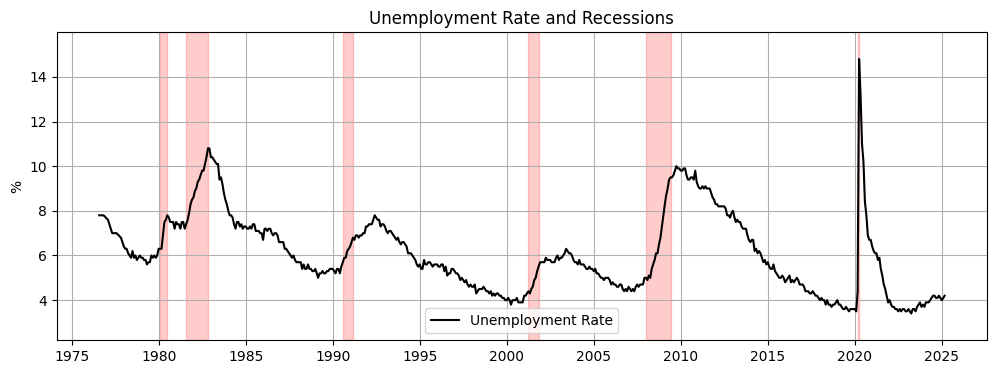

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Unemployment Rate'], color='black', label='Unemployment Rate')
plt.title('Unemployment Rate and Recessions')
plt.ylabel('%')
plt.fill_between(data.index, 0, 1, where=data['Recession'] == 1, color='red', alpha=0.2, transform=plt.gca().get_xaxis_transform())
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # Every 5 years
plt.show()



# Consumer Price Index (CPI) and Recessions
The CPI measures inflation by tracking changes in the prices of goods and services. Inflation tends to slow or reverse during recessions due to reduced consumer demand. The index is scaled so that prices in 1982‚Äì1984 equal 100. A value of 300 means prices have tripled since that baseline.


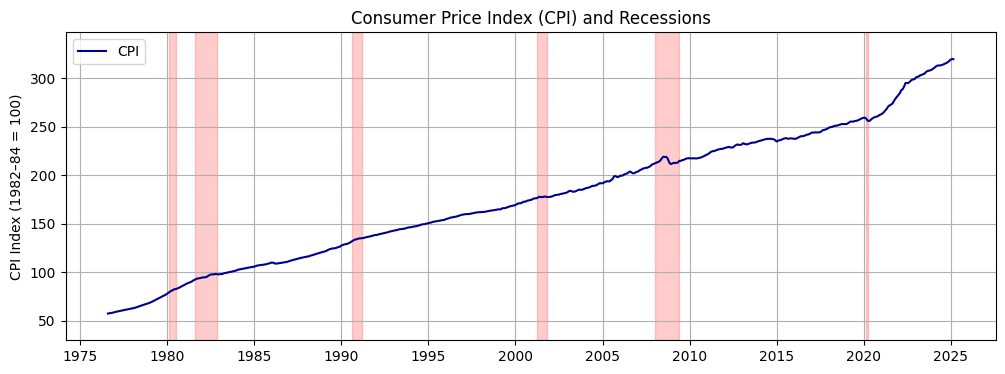

In [38]:
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['CPI'], color='darkblue', label='CPI')
plt.title('Consumer Price Index (CPI) and Recessions')
plt.ylabel('CPI Index (1982‚Äì84 = 100)')
plt.fill_between(data.index, 0, 1, where=data['Recession'] == 1, color='red', alpha=0.2, transform=plt.gca().get_xaxis_transform())
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # Every 5 years
plt.show()


# Federal Funds Rate and Recessions
This plot shows the Federal Reserve's target interest rate. The Fed often raises rates to fight inflation and lowers them in response to economic slowdowns or recessions.


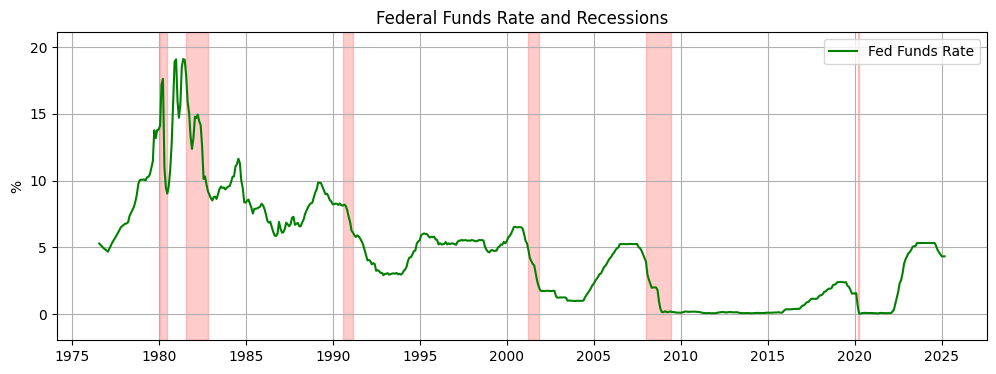

In [29]:
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Fed Funds Rate'], color='green', label='Fed Funds Rate')
plt.title('Federal Funds Rate and Recessions')
plt.ylabel('%')
plt.fill_between(data.index,0,1,where=data['Recession'] == 1,color='red',alpha=0.2,transform=plt.gca().get_xaxis_transform())
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # Every 5 years
plt.show()


# Yield Curve and Recessions
This plot tracks the difference between long-term (10-year) and short-term (2-year) U.S. Treasury yields. When the curve inverts (goes below 0), it historically signals a rising risk of recession.


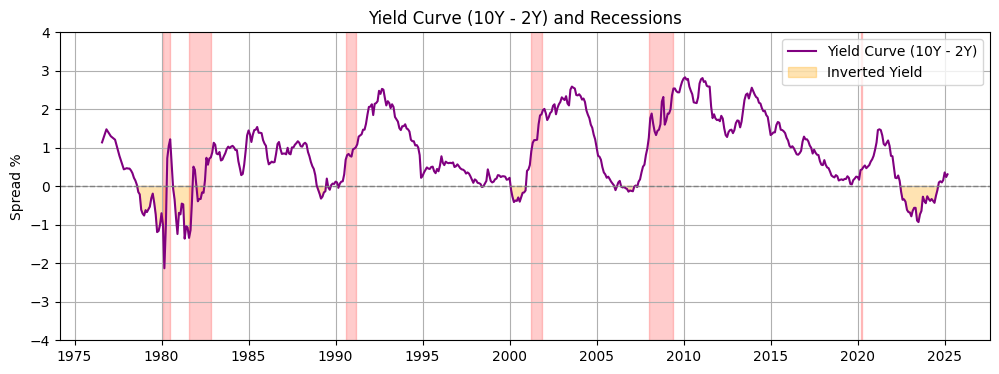

In [33]:
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Yield Curve'], color='purple', label='Yield Curve (10Y - 2Y)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.fill_between(
    data.index,
    data['Yield Curve'],
    where=(data['Yield Curve'] < 0),
    color='orange',
    alpha=0.3,
    label='Inverted Yield'
)
plt.fill_between(
    data.index,
    -2,
    2,
    where=data['Recession'] == 1,
    color='red',
    alpha=0.2,
    transform=plt.gca().get_xaxis_transform()
)
plt.title('Yield Curve (10Y - 2Y) and Recessions')
plt.ylabel('Spread %')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # Every 5 years
plt.ylim(-4, 4)
plt.show()


#Industrial Production and Recessions
This index tracks real output from U.S. factories, mines, and utilities. A sharp drop in production often aligns with the start of a recession. The index measures total industrial output in the U.S., scaled so that 2017 equals 100. Values below 100 indicate output was lower than in 2017, while values above 100 reflect higher production.

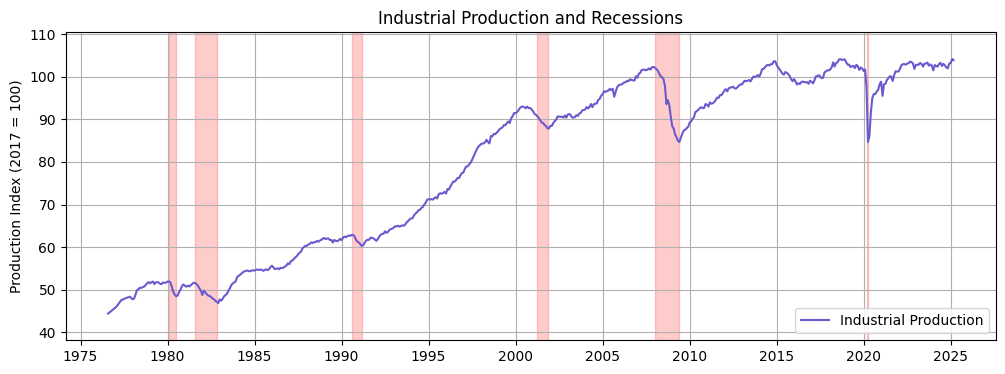

In [37]:
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Industrial Production'], color='slateblue', label='Industrial Production')
plt.title('Industrial Production and Recessions')
plt.ylabel('Production Index (2017 = 100)')
plt.fill_between(data.index, 0, 1, where=data['Recession'] == 1,color='red', alpha=0.2, transform=plt.gca().get_xaxis_transform())
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.show()


#Consumer Sentiment and Recessions
This index reflects how optimistic consumers feel about the economy. Falling sentiment usually signals weakening confidence and slower spending. The index is scaled so that a value of 100 represents the consumer sentiment level in 1966. Values above 100 mean stronger sentiment than in 1966; values below 100 mean weaker.

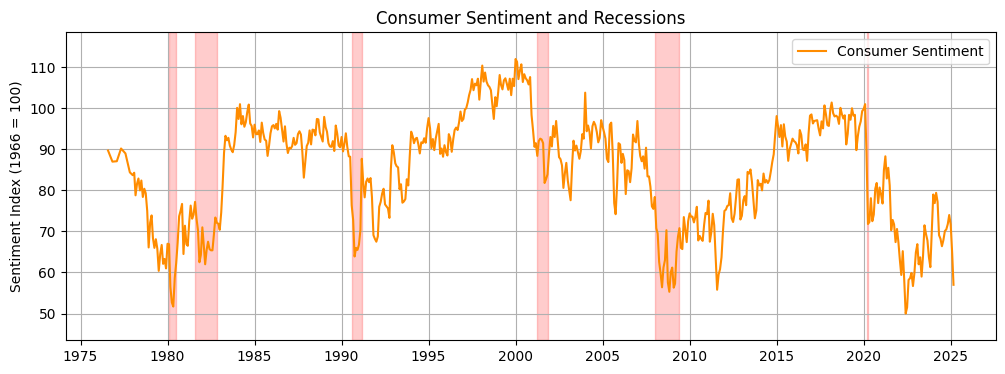

In [36]:
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Consumer Sentiment'], color='darkorange', label='Consumer Sentiment')
plt.title('Consumer Sentiment and Recessions')
plt.ylabel('Sentiment Index (1966 = 100)')
plt.fill_between(data.index, 0, 1, where=data['Recession'] == 1,color='red', alpha=0.2, transform=plt.gca().get_xaxis_transform())
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.show()


#Predicting Recessions Using Logistic Regression

To complement the visual analysis, I built a logistic regression model to estimate the probability of a recession based on several key indicators. This allows us to test whether patterns in the data can meaningfully predict recessions.


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Select features and target
features = ['Unemployment Rate', 'CPI', 'Fed Funds Rate', 'Yield Curve']
X = data[features]
y = data['Recession']

# Train-test split (chronologically)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Coefficients table
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

display(coef_df)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Print logistic regression equation
intercept = model.intercept_[0]
coefficients = model.coef_[0]

equation = f"Logit(P) = {intercept:.4f}"
for coef, feature in zip(coefficients, features):
    equation += f" + ({coef:.4f} √ó {feature})"

print("Logistic Regression Equation:")
print(equation)


Feature  Coefficient
3        Yield Curve     0.955718
2     Fed Funds Rate     0.511586
0  Unemployment Rate     0.113735
1                CPI     0.026483

Confusion Matrix:
 [[95 18]
 [ 2  0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.84      0.90       113
           1       0.00      0.00      0.00         2

    accuracy                           0.83       115
   macro avg       0.49      0.42      0.45       115
weighted avg       0.96      0.83      0.89       115

Logistic Regression Equation:
Logit(P) = -10.7420 + (0.1137 √ó Unemployment Rate) + (0.0265 √ó CPI) + (0.5116 √ó Fed Funds Rate) + (0.9557 √ó Yield Curve)


### üß† What the Model Tells Us

This simple model tries to predict whether the U.S. economy is heading into a recession by looking at four key indicators:

- **Yield Curve (0.96)** ‚Äì This is the strongest signal. When short-term interest rates are higher than long-term ones (called an inverted yield curve), it's often a sign that a recession is coming.
- **Federal Funds Rate (0.51)** ‚Äì When this interest rate set by the Federal Reserve goes up, the risk of recession also increases.
- **Unemployment Rate (0.11)** ‚Äì Higher unemployment slightly increases recession risk.
- **Inflation (CPI) (0.03)** ‚Äì Has a small effect in this model.

The numbers in parentheses shows how important each indicator was to the model. Bigger = more important.

---

### üìä How the Model Performed

**Prediction results:**

|                | Predicted: No Recession | Predicted: Recession |
|----------------|--------------------------|------------------------|
| **Actually No Recession** | 95 correct           | 18 incorrect         |
| **Actually Recession**    | 2 incorrect         | 0 correct            |

- The model was good at spotting normal (non-recession) periods.
- But it missed the actual recessions ‚Äî likely because they don‚Äôt happen often.

**Overall accuracy:** 83%  
(but this mostly comes from correctly guessing the "no recession" periods)

---

### üìù Takeaway

This isn‚Äôt a perfect prediction tool, but it shows which indicators matter most when trying to figure out if a recession is on the horizon. The yield curve especially stands out as a warning signal. Even with a simple model, we can start to see patterns in the economy.
